This notebook will develop a procudure for defining a Froude number.


# Froude number

Griffin and Leblond (1990) used a Froude number to identify periods of high mixing. The Froude number is defined as

$Fr = \frac{u}{c} $

where $u$ is the speed of the ebb current and $c$ is an internal wave speed. If $Fr$ > 1 then the flow is supercritical ad large internal waves can form leading to increased mixing. When $Fr<1$ less mixing is expected. 

They used an internal wave speed based on a two-layer stratifiction defined as

$c = \sqrt(g\frac{\rho_2-\rho_1}{\rho_2}h_1)$

where $g$ is the accelaration due to gravity, $\rho_2$ is the density of the lower layer and $\rho_1$ and $h_1$ are the density and thickness of the upper layer.

They found that $Fr<1$, is associated with pulses of fresh water at Race Rocks. This is because the fresh water exiting the Strait of Georgia through Haro Strait is less mixed when $Fr<1$. 

The describe neap tides as having a thicker surface layer and spring tides as having a thinner surface layer.

#Model

Next, I will attempt to work out the parameters needed to define $Fr$ from our model results.

##Loading files

In [1]:
import netCDF4 as nc
import numpy as np
from salishsea_tools import nc_tools
import datetime
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path = '/data/nsoontie/MEOPAR/SalishSea/results/2Ddomain/3.6'
directory = 'test_rivers'
file_part = 'SalishSea_4h_20020915_20021012_{}.nc'

dT = nc.Dataset(os.path.join(path,directory,file_part.format('grid_T')))
sal = dT.variables['vosaline'][:]
sal = np.ma.masked_values(sal,0)
deps = dT.variables['deptht'][:]
temp = dT.variables['votemper'][:]
temp = np.ma.masked_values(temp,0)
ssh = dT.variables['sossheig'][:]
n2 = dT.variables['buoy_n2'][:]
n2 = np.ma.masked_values(n2,0)
times = dT.variables['time_counter'][:]
time_origin = datetime.datetime.strptime(dT.variables['time_counter'].time_origin, '%Y-%m-%d %H:%M:%S')

dU = nc.Dataset(os.path.join(path,directory,file_part.format('grid_U')))
U = dU.variables['vozocrtx'][:]
U = np.ma.masked_values(U,0)
depsU=dU.variables['depthu'][:]

dW = nc.Dataset(os.path.join(path,directory,file_part.format('grid_W')))
avt = dW.variables['vert_eddy_diff'][:]
avt = np.ma.masked_values(avt,0)
avm = dW.variables['vert_eddy_visc'][:]
avm = np.ma.masked_values(avm,0)
depsW=dW.variables['depthw'][:]
diss = dW.variables['dissipation'][:]
diss = np.ma.masked_values(diss,0)


## $h_1$

We can use the buoyancy frequency to define the thickness of the surface layer. The surface layer should have a uniform stratification with depth which implies that the buoyancy frequency will be near zero in the surface layer.

So, we can define the $h_1$ as the first depth where the water column has buoyancy frequency greater than some small threshold. 

We can determine an average mixed layer depth by averaging over a region

In [3]:
def find_mixed_depth_indices(n2,t, n2_thresh=5e-6):
    """Finds the index of the mixed layer depth along a y slice at a time t.
    A mixed layer depth index for each x-position is calculated
    Mixed layer depth chosen based on lowest near-sruface vertical grid cell where n2 > n2_thres
    A resaonable value for n2_thresh is 5e-6.
    
    n2 is the masked array of buoyancy frequencies with dimensions time, depth, x
    
    returns list indices of mixed layer depth cell for each x-position
    """
    
    n2_sub = n2[t,:,:]
    
    dinds = []
    for ii in np.arange(n2_sub.shape[-1]):
        inds = np.where(n2_sub[:,ii] >=n2_thresh)
        #exlclude first vertical index less <=1 because the buoyancy frequency is hard to define there
        if inds[0].size:
            inds = filter(lambda x : x>1, inds[0])
            if inds:
                dinds.append(min(inds))
            else:
                dinds.append(0)
    return dinds

In [4]:
def average_mixed_layer_depth(mixed_depths, xmin, xmax):
    "Averages the mixed layer depths over indices xmin and xmax"
    
    mean_md = np.mean(mixed_depths[xmin:xmax+1])
    
    return mean_md

A spring tide

In [5]:
seconds_per_day = 86400.
yslice=5
n2_slice = np.squeeze(n2[:,:,yslice,:])
n2_slice.shape

(168, 40, 1100)

Average mld in sill region 8.32107


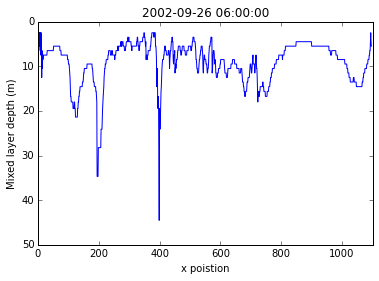

In [6]:
t=67
dinds =  find_mixed_depth_indices(n2_slice,t)
plt.plot(deps[dinds])
plt.axis([0,1100,50,0])
plt.xlabel('x poistion')
plt.ylabel('Mixed layer depth (m)')
plt.title(time_origin+datetime.timedelta(seconds=times[t]))

print 'Average mld in sill region', average_mixed_layer_depth(deps[dinds], 300, 700)

Another spring tide

Average mld in sill region 6.29302


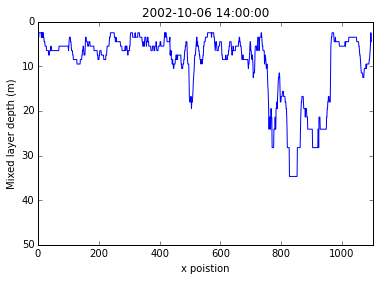

In [7]:

t=129
dinds =  find_mixed_depth_indices(n2_slice,t)
plt.plot(deps[dinds])
plt.axis([0,1100,50,0])
plt.xlabel('x poistion')
plt.ylabel('Mixed layer depth (m)')
plt.title(time_origin+datetime.timedelta(seconds=times[t]))

print 'Average mld in sill region', average_mixed_layer_depth(deps[dinds], 300, 700)

A neap tide

Average mld in sill region 6.82669


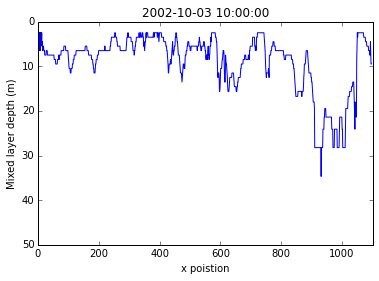

In [8]:
t=110
dinds =  find_mixed_depth_indices(n2_slice,t)
plt.plot(deps[dinds])
plt.axis([0,1100,50,0])
plt.xlabel('x poistion')
plt.ylabel('Mixed layer depth (m)')
plt.title(time_origin+datetime.timedelta(seconds=times[t]))

print 'Average mld in sill region', average_mixed_layer_depth(deps[dinds], 300, 700)

Over time

In [9]:
def mld_time_series(n2,deps,times,time_origin,xmin=300,xmax=700,n2_thresh=5e-6):
    """returns the mean mixed layer depth in a region defined by xmin and xmax over time
    n2 is the buoyancy frequency array with dimensions time, depth, x
    deps is the model deps array
    times is the model time_counter array
    time_origin is the mode's time_origin as a datetime
    
    returns a list of mixed layer depths mlds and dates
    """
    
    mlds=[]
    dates = []
    for t in np.arange(n2.shape[0]):
        dinds =  find_mixed_depth_indices(n2,t,n2_thresh=n2_thresh)
        mld = average_mixed_layer_depth(deps[dinds], xmin, xmax,)
        mlds.append(mld)
        dates.append(time_origin +datetime.timedelta(seconds=times[t]))
    
    return mlds, dates

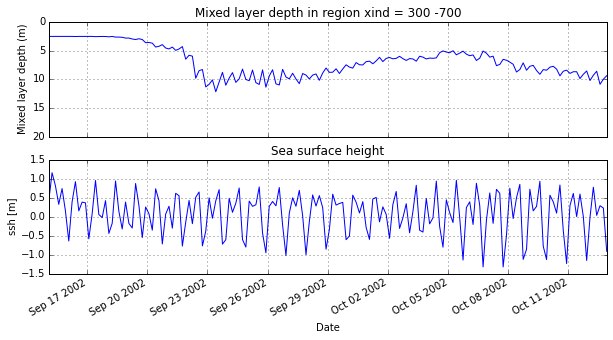

In [10]:
xmin=300; xmax=700
mlds, dates =mld_time_series(n2_slice,deps,times, time_origin)

fig,axs=plt.subplots(2,1,figsize=((10,5)),sharex=True)
#mlds
ax=axs[0]
ax.plot(dates, mlds)
ax.set_ylabel('Mixed layer depth (m)')
ax.set_title('Mixed layer depth in region xind = {} -{}'.format(xmin,xmax))
ax.set_ylim([20,0])
ax.grid()
#compare to tides
ax=axs[1]
ax.plot(dates,ssh[:,5,300])
ax.set_title('Sea surface height')
ax.set_ylabel('ssh [m]')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.grid()

* There is an initial adjustment period until about Sept 23.
* There does seem to be a spring/neap dependency on the mixed layer depth
* The trend is opposite to what is described in Griffin and Leblond. I have shallower mld in neap tide and deeper in spring tide. Why? Is there a lage between the tide phase and the mld transition?
* Maybe this idea isn't the best way to determine the thickness of the surface layer. I'm assuming the surface layer is all on constant density - is that right? 
* Other people would use a density > surface_density + density_threshold approach. Maybe I should to that? Will need to output the density. But this would return a value even if the water column is stratified all the way to the surface... 
* Values seem reasonable. Griffin and Leblond quote 10 m h1 in summer and 0 in winter.
* This simulation had no rivers. That might make a difference


###Sensitivity to n2_thres

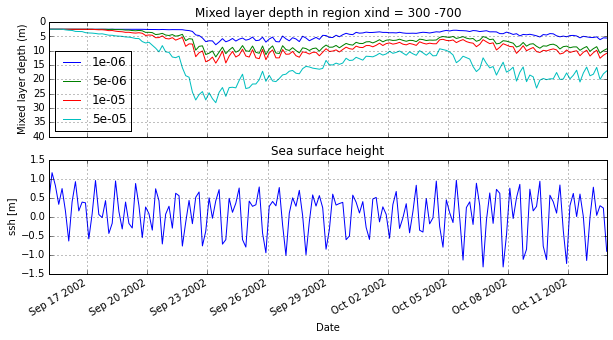

In [11]:
threshes = [1e-6, 5e-6, 1e-5, 5e-5]
xmin=300; xmax=700

fig,axs=plt.subplots(2,1,figsize=((10,5)),sharex=True)
ax=axs[0]
for thres in threshes:
    mlds, dates =mld_time_series(n2_slice,deps,times, time_origin,n2_thresh=thres)
    ax.plot(dates, mlds,label=thres)
#labels
ax.set_ylabel('Mixed layer depth (m)')
ax.set_title('Mixed layer depth in region xind = {} -{}'.format(xmin,xmax))
ax.set_ylim([40,0])
ax.grid()
ax.legend(loc=0)
#compare to tides
ax=axs[1]
ax.plot(dates,ssh[:,5,300])
ax.set_title('Sea surface height')
ax.set_ylabel('ssh [m]')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.grid()

5e-6 or 1e-5 seem like reasonable choices for the n2 threshold. But should evaluate again for a run with rivers.

Maybe also compare with NEMO's calculation of the mixed layer depth.